# Pet Image Classification using FastAI

## Introduction

This notebook demonstrates how to build and train a deep neural network for image classification using the FastAI library. We'll be working with the Oxford-IIIT Pet Dataset, which contains images of cats and dogs. Our goal is to create a model that can classify whether an image filename starts with an uppercase letter or not, which corresponds to different breeds in the dataset.

Throughout this notebook, we'll cover the following steps:
1. Loading and exploring the dataset
2. Preparing the data for training
3. Creating and training a convolutional neural network
4. Evaluating the model's performance

This project serves as an introduction to deep learning for computer vision tasks and showcases the simplicity and power of the FastAI library.

In [1]:
# Import required libraries
from fastai.vision.all import *
from fastai.interpret import Interpretation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

## Data Loading and Exploration

In [2]:
# Load and explore the dataset
path = untar_data(URLs.PETS)
print("Dataset contents:")
print(path.ls())

Dataset contents:
[Path('/Users/mark.watson/.fastai/data/oxford-iiit-pet/images'), Path('/Users/mark.watson/.fastai/data/oxford-iiit-pet/annotations')]


In [3]:
# Get image files and display dataset size
image_files = get_image_files(path/"images")
print(f"Total number of images: {len(image_files)}")

Total number of images: 7390


In [4]:
# Split data into training and test sets
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_files)}")
print(f"Test set size: {len(test_files)}")

Training set size: 5912
Test set size: 1478


In [5]:
# Display sample file paths
print("Sample image file paths:")
print(image_files[0])
print(image_files[6])

Sample image file paths:
/Users/mark.watson/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg
/Users/mark.watson/.fastai/data/oxford-iiit-pet/images/Birman_167.jpg


In [6]:
# Define labeling function
def label_func(file_path):
    """
    Label images based on the first letter of the filename.
    Returns True if the first letter is uppercase, False otherwise.
    """
    return file_path[0].isupper()

DataLoaders is a FastAI class that manages loading and batching of data for training and validation. It handles tasks like shuffling, batching, and applying transformations to your dataset, making it easier to feed data into your model.

In [7]:
# Create DataLoaders
data_loaders = ImageDataLoaders.from_name_func(
    path, train_files, label_func, item_tfms=Resize(224)
)

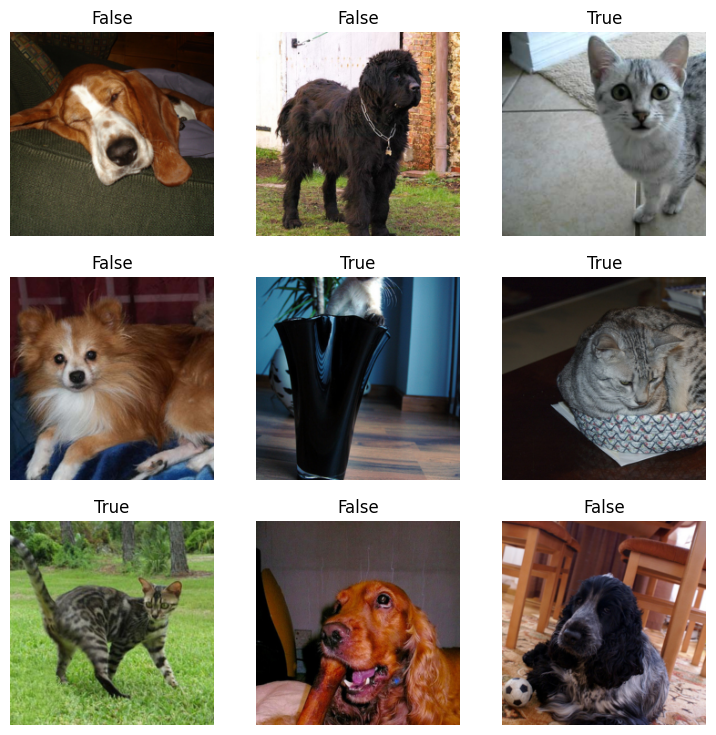

In [8]:
# Display a batch of images
data_loaders.show_batch()

## Model Creation and Training

`vision_learner` is a FastAI function that creates a convolutional neural network (CNN) for computer vision tasks. It sets up a pre-trained model (like ResNet34) and adapts it for your specific task, handling details like the head of the network and loss function.

Fine tuning is a technique where you take a pre-trained model and adjust its parameters for a new, related task. The fine_tune method in FastAI gradually unfreezes layers of the model and trains them on your specific dataset, allowing the model to adapt to your task while leveraging pre-trained weights.

In [9]:
# Create and train the model
model = vision_learner(data_loaders, resnet34, metrics=error_rate)
model.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.191418,0.021313,0.005922,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.057447,0.013732,0.004230,00:47


## Model Evaluation

In [10]:
# Evaluate the model on the test set
test_data_loader = model.dls.test_dl(test_files)
predictions, _ = model.get_preds(dl=test_data_loader)
predicted_labels = predictions.argmax(dim=1)
true_labels = torch.tensor([label_func(str(f.name)) for f in test_files])

In [11]:
# Calculate and display accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9959


In [12]:
# Display classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['False', 'True']))


Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       981
        True       0.99      0.99      0.99       497

    accuracy                           1.00      1478
   macro avg       1.00      1.00      1.00      1478
weighted avg       1.00      1.00      1.00      1478



In [16]:
df = pd.DataFrame({
    'confidence': confidences.numpy(),
    'correct': correct.numpy(),
    'true_label': true_labels.numpy()
})

df['bin'] = pd.cut(df['confidence'], bins)

result = df.groupby('bin', observed=True).agg({
    'correct': 'mean',
    'true_label': ['count', 'sum']
}).reset_index()

result.columns = ['Confidence Bin', 'Total Accuracy', 'Total Count', 'True Label Count']
result['False Label Count'] = result['Total Count'] - result['True Label Count']

# Calculate accuracies separately and handle missing values
true_label_accuracy = df[df['true_label']].groupby('bin', observed=True)['correct'].mean()
false_label_accuracy = df[~df['true_label']].groupby('bin', observed=True)['correct'].mean()

result['True Label Accuracy'] = result['Confidence Bin'].map(true_label_accuracy).fillna(0)
result['False Label Accuracy'] = result['Confidence Bin'].map(false_label_accuracy).fillna(0)

# Convert accuracies to percentages
accuracy_columns = ['True Label Accuracy', 'False Label Accuracy', 'Total Accuracy']
result[accuracy_columns] = result[accuracy_columns] * 100

# Format the confidence bins
result['Confidence Bin'] = result['Confidence Bin'].apply(lambda x: f"{x.left:.1f}-{x.right:.1f}")

result = result[['Confidence Bin', 'True Label Accuracy', 'True Label Count', 
                 'False Label Accuracy', 'False Label Count', 
                 'Total Accuracy', 'Total Count']]

display(result.style.format({
    'True Label Accuracy': '{:.0f}%',
    'False Label Accuracy': '{:.0f}%',
    'Total Accuracy': '{:.0f}%',
    'True Label Count': '{:,}',
    'False Label Count': '{:,}',
    'Total Count': '{:,}'
}))

,Confidence Bin,True Label Accuracy,True Label Count,False Label Accuracy,False Label Count,Total Accuracy,Total Count
0,0.5-0.6,100%,2,0%,0,100%,2
1,0.6-0.7,0%,0,100%,1,100%,1
2,0.7-0.8,60%,5,75%,4,67%,9
3,0.8-0.9,0%,0,100%,4,100%,4
4,0.9-1.0,100%,490,100%,972,100%,"1,462"
